<a href="https://colab.research.google.com/github/malinphy/q_17/blob/main/biogpt_variants_biogpt_large_nih.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install scann -q

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 86.0 MB/s eta 0:00:00


In [14]:
import numpy as np 
import pandas as pd 
from platform import python_version
import os 
import sklearn
import json
# from data_loader import patent_data
# from data_diluter import normalizer
# from data_diluter import  diluted_df
from sklearn.decomposition import TruncatedSVD, PCA
import joblib
import math
import matplotlib.pyplot as plt
import scann
plt.style.use('ggplot')

In [3]:
os.listdir('drive/MyDrive/transfer/biogpt_variants/biogpt_large')

['data_nih_abstract_biogpt_large.npy',
 'data_nih_title_biogpt_large_norm.npy',
 'data_nih_abstract_biogpt_large_norm.npy',
 'data_biotech_title_biogpt_large.npy',
 'data_biotech_abstract_biogpt_large.npy',
 'data_biotech_abstract_biogpt_large_norm.npy',
 'data_biotech_title_biogpt_large_norm.npy',
 'data_nih_title_biogpt_large.npy']

In [4]:
def vector_normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    hits = []
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        hits.append(num_hits)
    # if not actual:
    #     return 0.0
    # print(((hits)))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def intersect(actual, predicted,k):
    return np.intersect1d(actual[:k], predicted[:k])

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(actual[i], predicted[i],k)
        total = total + len(intersection)

    return total


def mean_reciprocal_rank(idx, k):
    rank = []
    for i in range(len(idx)):
        rank.append(np.where(idx[i][:k] == i)[0])

    elevated_rank = np.add(rank,1)
    elevated_rank = np.concatenate(elevated_rank)
    elevated_rank_len = len(elevated_rank)
    reciprocal_rank = np.divide(1,elevated_rank)
    reciprocal_rank_sum = np.sum(reciprocal_rank)
    # print('asfasfasfas',len(idx))
    # return reciprocal_rank_sum/elevated_rank_len
    return reciprocal_rank_sum/len(idx)    

def dcg_calc(similarity_scores, K):
    similarity_len = len(similarity_scores)
    total_dcg = []
    for similarities in similarity_scores:
        dcg = 0
        for k in range(1,K):
            rel_k = similarities[k-1]
            dcg += rel_k / log2(1 + k)
        total_dcg.append(dcg)
    return np.sum(total_dcg)/similarity_len    

def metrics_calculator(raw_idx, reduced_idx, k_values):
    k = k_values
    ap = []
    hit = []
    mrr = []
    for i in k:
        ap.append( mapk(raw_idx, reduced_idx,i))
        hit.append( hit_rate(raw_idx, reduced_idx,i))
        mrr.append(mean_reciprocal_rank(reduced_idx, i))
    return ap, hit , mrr  

In [5]:
def vector_normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

In [9]:
nih_abstract_biogpt_large = np.load('drive/MyDrive/transfer/biogpt_variants/biogpt_large/data_nih_abstract_biogpt_large_norm.npy')
nih_title_biogpt_large = np.load('drive/MyDrive/transfer/biogpt_variants/biogpt_large/data_nih_title_biogpt_large_norm.npy')

# biotech_abstract_biogpt_large_pubmed_qa = np.load('drive/MyDrive/transfer/biogpt_variants/biogpt_large_pubmed_qa/data_nih_abstract_biogpt_Large_PubMedQA_norm.npy')
# biotech_title_biogpt_large_pubmed_qa = np.load('drive/MyDrive/transfer/biogpt_variants/biogpt_large_pubmed_qa/data_nih_title_biogpt_Large_PubMedQA_norm.npy')

Text(0.5, 1.0, 'biogpt_large')

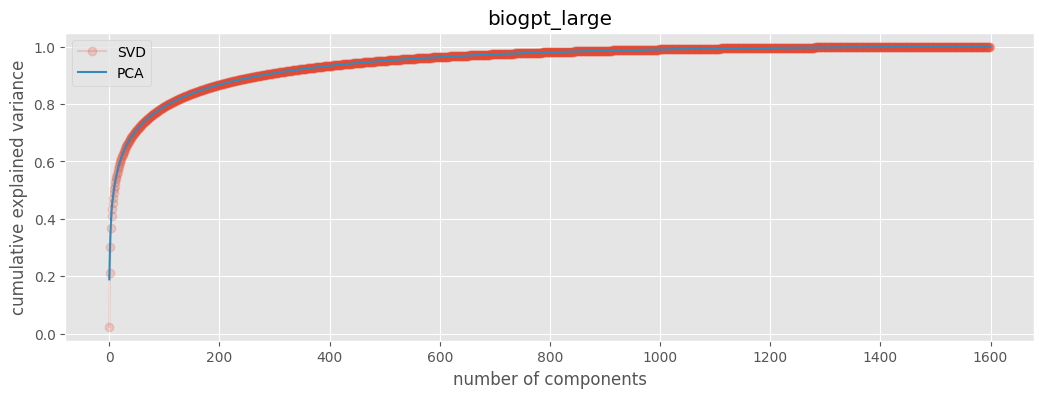

In [15]:
pca_biogpt_large = PCA().fit(nih_abstract_biogpt_large)
pca_var_nih_large = np.cumsum(pca_biogpt_large.explained_variance_ratio_)

svd_content_nih_large = TruncatedSVD(n_iter= 25, n_components = 1600 ).fit(nih_abstract_biogpt_large)
svd_var_nih_large = np.cumsum(svd_content_nih_large.explained_variance_ratio_)
     
plt.figure(figsize = (12.5,4))
plt.plot(svd_var_nih_large, marker = 'o', alpha =0.2)
plt.plot(pca_var_nih_large)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.legend(['SVD','PCA'])
plt.title('biogpt_large')

In [13]:
print('PCA 100% :',np.where(np.array(pca_var_nih_large) >= 0.99)[0][0])
print('SVD 100% :',np.where(np.array(svd_var_nih_large) >= 0.99)[0][0])
print('PCA 95% :',np.where(np.array(pca_var_nih_large) >= 0.95)[0][0])
print('SVD 95% :',np.where(np.array(svd_var_nih_large) >= 0.95)[0][0])
print('PCA 90% :',np.where(np.array(pca_var_nih_large) >= 0.90)[0][0])
print('SVD 90% :',np.where(np.array(svd_var_nih_large) >= 0.90)[0][0])

PCA 100% : 989
SVD 100% : 989
PCA 95% : 492
SVD 95% : 492
PCA 90% : 276
SVD 90% : 277
